<a href="https://colab.research.google.com/github/GhazalehKeyvani/MTTQA/blob/main/MTTQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Setup and Imports


In [12]:
pip install langchain langchain-openai langchain-community langgraph openai chromadb pandas numpy python-dotenv tiktoken pydantic

  Using cached langchain_openai-1.1.10-py3-none-any.whl.metadata (3.1 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached build-1.4.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached onnxruntime-1.24.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.0 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.39.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached pypika-0.51.1-py2.py3-none-any.whl.metadata (51 kB)
  Using cached bcrypt-5.0.0-cp39-abi3-manylinux_2_34_x86_64.whl.metadata (10 kB)
  Using cached kubernetes-35.0.0-py2.py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2

In [1]:
!pip install langchain==0.2.3 langchain-openai langchain-community==0.2.3 langgraph==0.1.1 openai==1.30.1 chromadb==0.5.0 pandas==2.2.2 numpy==1.26.4 python-dotenv==1.0.1 tiktoken==0.6.0 pydantic==2.7.1

  Using cached langchain-0.2.3-py3-none-any.whl.metadata (6.9 kB)
  Using cached langchain_community-0.2.3-py3-none-any.whl.metadata (9.0 kB)
  Using cached langgraph-0.1.1-py3-none-any.whl.metadata (11 kB)
  Using cached openai-1.30.1-py3-none-any.whl.metadata (21 kB)
  Using cached chromadb-0.5.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached tiktoken-0.6.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached pydantic-2.7.1-py3-none-any.whl.metadata (107 kB)
  Using cached langchain_core-0.2.43-py3-none-any.whl.metadata (6.2 kB)
  Using cached langchain_text_splitters-0.2.4-py3-none-any.whl.metadata (2.3 kB)
  Using cached langsmith-0.1.147-py3-none-any.whl.metadata (14 kB)
  Using cached tenacity-8.5.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached chroma-hnswlib-0.7.3

In [12]:
pip install rouge-score nltk sentence-transformers scikit-learn

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=24af919fb3450c8c789f15a9e490589dbc284f436c7d84b3635ac254a4cabc2b
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [2]:
import os
import json
import re
import pandas as pd
import numpy as np
from typing import TypedDict, List, Dict, Any, Optional
from dotenv import load_dotenv

# LangChain / LangGraph
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.tools import tool, Tool, BaseTool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# Pydantic for tool schemas
from pydantic import BaseModel, Field

# (Optional) if you need AgentExecutor later
#from langchain.agents import AgentExecutor

In [3]:
import requests
import json
import os
from pathlib import Path

# Create path
data_dir = Path("./TAT_QA")
data_dir.mkdir(exist_ok=True)

# Download Files: train، dev و test
base_url = "https://huggingface.co/datasets/TableQAKit/TAT-QA/resolve/main/"
files = ["tatqa_dataset_train.json", "tatqa_dataset_dev.json", "tatqa_dataset_test.json"]

for file in files:
    url = base_url + file
    response = requests.get(url)
    if response.status_code == 200:
        with open(data_dir / file, 'wb') as f:
            f.write(response.content)
        print(f"✅ {file} Downloaded")
    else:
        print(f"❌ Download error {file}")

# Uploade data
def load_tatqa(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

train_data = load_tatqa(data_dir / "tatqa_dataset_train.json")
print(f"\n Number of train: {len(train_data)}")
print(f"A sample structure \n{json.dumps(train_data[0], indent=2)[:500]}...")

✅ tatqa_dataset_train.json Downloaded
✅ tatqa_dataset_dev.json Downloaded
✅ tatqa_dataset_test.json Downloaded

 Number of train: 2204
A sample structure 
{
  "table": {
    "uid": "2afe0a52e5a2dec3bb6c67450fcd5222",
    "table": [
      [
        "",
        "F19",
        "F18",
        "",
        "CHANGE"
      ],
      [
        "$ MILLION",
        "53 WEEKS",
        "52 WEEKS",
        "CHANGE",
        "NORMALISED"
      ],
      [
        "Sales",
        "3,797",
        "3,566",
        "6.5%",
        "4.2%"
      ],
      [
        "LBITDA before",
        "",
        "",
        "",
        ""
      ],
      [
        "significant i...


In [4]:

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("Please set OPENAI_API_KEY in .env file")

# Configuration
MODEL_NAME = "gpt-4o-mini"  # Use a cost-effective model; replace with open-source if needed
TEMPERATURE = 0
VECTOR_STORE_PATH = "./chroma_db"
TATQA_PATH = "./TAT_QA/"  # Path to dataset (should contain train.json, dev.json, test.json)

# We'll use OpenAI embeddings for text retrieval
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Instantiate the LLM
llm = ChatOpenAI(model=MODEL_NAME, temperature=TEMPERATURE)

## 2. Load and Preprocess TAT-QA Data

In [5]:
def load_tatqa_split(split: str):
    with open(os.path.join(TATQA_PATH, f"{split}.json"), "r") as f:
        data = json.load(f)
    return data

# Load a small subset for demonstration (use full for evaluation)
train_data = load_tatqa_split("tatqa_dataset_train")[:5]   # Take first 5 for quick demo
dev_data = load_tatqa_split("tatqa_dataset_dev")[:2]
test_data = load_tatqa_split("tatqa_dataset_test")[:2]

print(f"Train samples: {len(train_data)}")
print(f"Dev samples: {len(dev_data)}")
print(f"Test samples: {len(test_data)}")

Train samples: 5
Dev samples: 2
Test samples: 2


### 2.1 Inspect a sample

In [6]:
sample = train_data[0]
print("Table UID:", sample["table"]["uid"])
print("Table:\n", pd.DataFrame(sample["table"]["table"]))
print("\nParagraphs:")
for p in sample["paragraphs"]:
    print(f"  [{p['order']}] {p['text']}")
print("\nQuestions:")
for q in sample["questions"]:
    print(f"  Q: {q['question']}  A: {q['answer']} (type: {q['answer_type']})")

Table UID: 2afe0a52e5a2dec3bb6c67450fcd5222
Table:
                                 0         1         2          3           4
0                                       F19       F18                 CHANGE
1                       $ MILLION  53 WEEKS  52 WEEKS     CHANGE  NORMALISED
2                           Sales     3,797     3,566       6.5%        4.2%
3                   LBITDA before                                           
4               significant items       (5)      (30)    (82.2)%     (88.7)%
5   Depreciation and amortisation      (80)      (80)       0.7%        0.7%
6   LBIT before significant items      (85)     (110)    (22.2)%     (24.0)%
7               Significant items     (371)         –       n.m.        n.m.
8    LBIT after significant items     (456)     (110)     315.5%      313.7%
9                Gross margin (%)      31.1      31.7   (59) bps    (49) bps
10     Cost of doing business (%)      33.4      34.8  (142) bps   (132) bps
11            LBIT 2 to 

## 3. Build Vector Store for Paragraphs


We will index all paragraphs from the dataset for retrieval. For simplicity, we only index the training set paragraphs.

In [7]:
def prepare_paragraphs(data):
    docs = []
    ids = []
    for sample in data:
        for p in sample["paragraphs"]:
            docs.append(p["text"])
            ids.append(p["uid"])
    return docs, ids

train_paragraphs, train_para_ids = prepare_paragraphs(train_data)
print(f"Indexing {len(train_paragraphs)} paragraphs...")

# Create vector store (if not exists)
if not os.path.exists(VECTOR_STORE_PATH):
    vectorstore = Chroma.from_texts(
        texts=train_paragraphs,
        embedding=embeddings,
        metadatas=[{"uid": uid} for uid in train_para_ids],
        persist_directory=VECTOR_STORE_PATH
    )
    vectorstore.persist()
else:
    vectorstore = Chroma(persist_directory=VECTOR_STORE_PATH, embedding_function=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

Indexing 13 paragraphs...


/tmp/ipython-input-12780/4097979710.py:21: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


## 4. Define Tools
Each tool will be callable by the agents.

In [8]:
# Tool 1: Table Query Tool
def table_query_tool(query: str, table_df: pd.DataFrame) -> str:
    """
    Execute a natural language query on a pandas DataFrame and return result as string.
    In a production system, you would use an LLM to convert the query to pandas code.
    For this demo, we implement a simple keyword-based cell lookup.
    """
    # Very simple parser: try to find cell by row/column keywords
    # For full implementation, use an LLM to generate pandas code.
    query_lower = query.lower()
    # Try to extract a year (e.g., 2019)
    import re
    year_match = re.search(r'\b(20\d{2})\b', query)
    col = None
    if year_match:
        col = year_match.group(1)
    # Try to extract a row name
    row_keywords = ['revenue', 'income', 'profit', 'cost', 'assets']
    row = None
    for kw in row_keywords:
        if kw in query_lower:
            row = kw.capitalize()
            break
    # If both found, try to locate cell
    if col and row:
        # Assume first row is header
        if col in table_df.columns:
            mask = table_df.iloc[:, 0].astype(str).str.contains(row, case=False, na=False)
            if mask.any():
                value = table_df.loc[mask, col].values[0]
                return f"The value for {row} in {col} is {value}."
    return "Could not locate exact cell. Please refine your query."

# Wrap as LangChain tool
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field

class TableQueryInput(BaseModel):
    query: str = Field(description="Natural language query about the table")
    table_df: Any = Field(description="Pandas DataFrame of the table")

class TableQueryTool(BaseTool):
    name: str = "table_query"
    description: str = "Query the table to retrieve a specific cell value based on row and column descriptions."
    args_schema: type[BaseModel] = TableQueryInput

    def _run(self, query: str, table_df: pd.DataFrame) -> str:
        return table_query_tool(query, table_df)

    async def _arun(self, query: str, table_df: pd.DataFrame) -> str:
        raise NotImplementedError

# Tool 2: Text Retriever Tool
def text_retriever_tool(question: str) -> str:
    """Retrieve relevant paragraphs from the document."""
    docs = retriever.invoke(question)   # ✅ use invoke
    if not docs:
        return "No relevant text found."
    return "\n\n".join([doc.page_content for doc in docs])

text_retriever_tool_obj = Tool(
    name="text_retriever",
    func=text_retriever_tool,
    description="Retrieve paragraphs relevant to the question."
)

# Tool 3: Calculator Tool
def calculator_tool(expression: str) -> str:
    """Safely evaluate a mathematical expression."""
    try:
        # Use a safe eval
        allowed_names = {"abs": abs, "round": round, "min": min, "max": max}
        code = compile(expression, "<string>", "eval")
        for name in code.co_names:
            if name not in allowed_names:
                raise NameError(f"Use of {name} not allowed")
        result = eval(code, {"__builtins__": {}}, allowed_names)
        return str(result)
    except Exception as e:
        return f"Error: {e}"

calculator_tool_obj = Tool(
    name="calculator",
    func=calculator_tool,
    description="Perform arithmetic calculations. Input should be a valid Python expression."
)

# Tool 4: Knowledge Graph Lookup (optional, simplified)
def kg_lookup_tool(entity: str) -> str:
    """Look up an entity in a simple in-memory knowledge graph."""
    # For demo, return static info; in real system, query a graph DB.
    return f"Found information about {entity}: ..."

kg_tool = Tool(
    name="kg_lookup",
    func=kg_lookup_tool,
    description="Look up an entity in the knowledge graph."
)

# Collect all tools
tools = [text_retriever_tool_obj, calculator_tool_obj, kg_tool]  # table tool will be called separately with df

## 5. Define Agent Nodes for LangGraph

We'll define a state that holds all necessary information.

In [37]:
class AgentState(TypedDict):
    question: str
    table_df: Optional[pd.DataFrame]
    table_headers: Optional[List[str]]
    table_rows: Optional[List[List[str]]]
    paragraphs: List[str]
    retrieved_texts: List[str]
    retrieved_paragraph_ids: List[int] # Add this line
    extracted_numbers: List[float]
    plan: List[str]
    intermediate_results: Dict[str, Any]
    final_answer: Optional[str]
    error: Optional[str]

# We will create nodes that update the state.

# Node 1: Planning Agent
def planning_agent(state: AgentState) -> AgentState:
    """Analyse the question and produce a step-by-step plan."""
    messages = [
        SystemMessage(content="You are a planning agent for table-and-text question answering. "
                              "Given a question, produce a numbered list of steps to answer it. "
                              "Use the available tools: text_retriever, calculator, kg_lookup, and a table query tool (which you will call later)."),
        HumanMessage(content=state["question"])
    ]
    response = llm.invoke(messages)
    plan = response.content.strip().split("\n")
    state["plan"] = plan
    return state

def verification_agent(state: AgentState) -> AgentState:
    """Check the consistency of the answer and produce final answer."""
    context = f"Question: {state['question']}\n"
    if "table_value" in state["intermediate_results"]:
        context += f"Table value: {state['intermediate_results']['table_value']}\n"
    if "retrieved_texts" in state:
        context += f"Retrieved texts: {' '.join(state['retrieved_texts'])}\n"
    if "calculation_result" in state["intermediate_results"]:
        context += f"Calculation result: {state['intermediate_results']['calculation_result']}\n"

    messages = [
        SystemMessage(content="You are a verification agent. Based on the evidence, provide a concise final answer to the question."),
        HumanMessage(content=context)
    ]
    response = llm.invoke(messages)
    state["final_answer"] = response.content.strip()
    return state

# Node 2: Table Parsing Agent
def table_parsing_agent(state: AgentState) -> AgentState:
    """Extract necessary information from the table based on the plan."""
    if not state["table_headers"] or not state["table_rows"]:
        state["error"] = "No table provided."
        return state

    # Build DataFrame locally (safe, not stored in state)
    df = pd.DataFrame(state["table_rows"], columns=state["table_headers"])

    # (Rest of your logic unchanged – use df)
    import re
    years = re.findall(r'\b(20\d{2})\b', state["question"])
    if years:
        year = years[0]
        row_names = df.iloc[:, 0].tolist()
        keywords = ['revenue', 'income', 'profit', 'cost', 'assets']
        found_row = None
        for kw in keywords:
            if kw in state["question"].lower():
                for rn in row_names:
                    if kw in str(rn).lower():
                        found_row = rn
                        break
                if found_row:
                    break
        if found_row and year in df.columns:
            val = df.loc[df.iloc[:, 0] == found_row, year].values[0]
            state["intermediate_results"]["table_value"] = val
            state["intermediate_results"]["table_row"] = found_row
    return state

    # Use the plan to decide what to extract
    # For demo, we hardcode a simple extraction: look for a year mentioned
    import re
    years = re.findall(r'\b(20\d{2})\b', state["question"])
    if years:
        year = years[0]
        # Try to get a relevant row
        # Assume first column is row names
        row_names = df.iloc[:, 0].tolist()
        # Find a row matching some keyword from question
        keywords = ['revenue', 'income', 'profit', 'cost', 'assets']
        found_row = None
        for kw in keywords:
            if kw in state["question"].lower():
                # find first row containing that keyword
                for rn in row_names:
                    if kw in str(rn).lower():
                        found_row = rn
                        break
                if found_row:
                    break
        if found_row and year in df.columns:
            val = df.loc[df.iloc[:, 0] == found_row, year].values[0]
            state["intermediate_results"]["table_value"] = val
            state["intermediate_results"]["table_row"] = found_row
    return state

# Node 3: Text Retrieval Agent
# def text_retrieval_agent(state: AgentState) -> AgentState:
#     """Retrieve relevant paragraphs."""
#     question = state["question"]
#     # Debugging: Print type and attributes of retriever
#     # print(f"Debug: Type of retriever: {type(retriever)}")
#     # print(f"Debug: Attributes of retriever: {dir(retriever)}")

#     docs = retriever.invoke(question)
#     retrieved = [doc.page_content for doc in docs]
#     state["retrieved_texts"] = retrieved
#     return state
def text_retrieval_agent(state: AgentState) -> AgentState:
    print("Debug: Entering text_retrieval_agent")
    docs = retriever.invoke(state["question"])
    state["retrieved_texts"] = [doc.page_content for doc in docs]
    # ذخیره شناسه‌ها (مثلاً order) – اگر وجود نداشت، از اندیس استفاده کنید
    retrieved_ids = [
        doc.metadata.get("order", i) for i, doc in enumerate(docs)
    ]
    state["retrieved_paragraph_ids"] = retrieved_ids
    print(f"Debug: Retrieved {len(retrieved_ids)} paragraph IDs: {retrieved_ids}")
    return state
# Node 4: Calculation Agent
def calculation_agent(state: AgentState) -> AgentState:
    """Perform calculations based on extracted numbers."""
    # This agent uses the calculator tool.
    # For demonstration, we check if we need to compute something.
    # We can parse the plan for an arithmetic step.
    # Hardcoded: if question asks for "difference" or "change", we compute.
    q_lower = state["question"].lower()
    if "difference" in q_lower or "change" in q_lower:
        # Need two numbers. Try to get them from intermediate results.
        vals = state["intermediate_results"]
        # In a real system, we would have extracted numbers from table and text.
        # For demo, we simulate with dummy numbers.
        num1 = vals.get("table_value", 100)
        num2 = vals.get("text_value", 50)
        expr = f"{num1} - {num2}"
        result = calculator_tool(expr)
        state["intermediate_results"]["calculation_result"] = result
    return state

# Node 5: Verification Agent
# def verification_agent(state: AgentState) -> AgentState:
#     """Check the consistency of the answer and produce final answer."""
#     # Use LLM to generate final answer based on all evidence.
#     context = f"Question: {state['question']}\n"
#     if "table_value" in state["intermediate_results"]:
#         context += f"Table value: {state['intermediate_results']['table_value']}\n"
#     if "retrieved_texts" in state:
#         context += f"Retrieved texts: {' '.join(state['retrieved_texts'])}\n"
#     if "calculation_result" in state["intermediate_results"]:
#         context += f"Calculation result: {state['intermediate_results']['calculation_result']}\n"
#     prompt = ChatPromptTemplate.from_messages([
#         SystemMessage(content="You are a verification agent. Based on the evidence, provide a concise final answer to the question."),
#         HumanMessage(content=context)
#     ])
#     response = llm.invoke(prompt.format_messages())
#     state["final_answer"] = response.content.strip()
#     return state


# def verification_agent(state: AgentState) -> AgentState:
#     context = f"Question: {state['question']}\n"
#     if "table_value" in state["intermediate_results"]:
#         context += f"Table value: {state['intermediate_results']['table_value']}\n"
#     if "retrieved_texts" in state:
#         context += f"Retrieved texts: {' '.join(state['retrieved_texts'])}\n"
#     if "calculation_result" in state["intermediate_results"]:
#         context += f"Calculation result: {state['intermediate_results']['calculation_result']}\n"

#     messages = [
#         SystemMessage(content="You are a verification agent. Based on the evidence, provide the final answer concisely. Output ONLY the answer value, without any explanation or extra words."),
#         HumanMessage(content=context)
#     ]
#     response = llm.invoke(messages)
#     state["final_answer"] = response.content.strip()
#     return state

def verification_agent(state: AgentState) -> AgentState:
    """
    Produces the final answer based on all evidence.
    Uses different prompt styles for numeric vs. descriptive questions.
    """
    # Build context from all available evidence
    context = f"Question: {state['question']}\n\n"

    if "retrieved_texts" in state and state["retrieved_texts"]:
        context += "Relevant paragraphs:\n"
        for i, txt in enumerate(state["retrieved_texts"]):
            context += f"{i+1}. {txt}\n"

    if "table_value" in state["intermediate_results"]:
        context += f"\nTable value: {state['intermediate_results']['table_value']}\n"

    if "calculation_result" in state["intermediate_results"]:
        context += f"Calculation result: {state['intermediate_results']['calculation_result']}\n"

    # Classify question type
    q_lower = state["question"].lower()
    numeric_keywords = [
        "how much", "what is the amount", "gross margin",
        "percentage", "what is the value", "how many",
        "total", "sum", "difference", "change", "average"
    ]
    is_numeric = any(kw in q_lower for kw in numeric_keywords)

    if is_numeric:
        system_msg = (
            "You are a verification agent for financial tables and text. "
            "Based on the evidence provided, output ONLY the numeric answer "
            "with its unit (%, $, etc.) if applicable. Do not add any extra words, "
            "explanations, or formatting."
        )
    else:
        system_msg = (
            "You are a verification agent for financial tables and text. "
            "Based on the evidence provided, output the complete answer exactly "
            "as stated in the evidence. Do not add any extra words or explanations."
        )

    messages = [
        SystemMessage(content=system_msg),
        HumanMessage(content=context)
    ]

    response = llm.invoke(messages)
    answer = response.content.strip()

    # Handle potential list output (if model returns a list)
    if isinstance(answer, list):
        answer = " ".join(str(x) for x in answer)

    state["final_answer"] = answer
    return state


# Node 6: Error Handler
def error_handler(state: AgentState) -> AgentState:
    """Handle errors gracefully."""
    if state.get("error"):
        state["final_answer"] = f"An error occurred: {state['error']}"
    return state

## 6. Build the LangGraph
We'll create a state graph with conditional edges.

In [38]:
from langgraph.graph import StateGraph, END

# Initialize graph
graph = StateGraph(AgentState)

# Add nodes
graph.add_node("planner", planning_agent)
graph.add_node("table_parser", table_parsing_agent)
graph.add_node("text_retriever", text_retrieval_agent)
graph.add_node("calculator", calculation_agent)
graph.add_node("verifier", verification_agent)
graph.add_node("error_handler", error_handler)

# Set entry point
graph.set_entry_point("planner")

# Define conditional routing from planner
def route_from_planner(state: AgentState):
    # If question involves table, go to table_parser, else skip.
    if "table" in state["question"].lower():
        return "table_parser"
    else:
        return "text_retriever"

graph.add_conditional_edges("planner", route_from_planner, {
    "table_parser": "table_parser",
    "text_retriever": "text_retriever"
})

# After table_parser, go to text_retriever if needed
graph.add_edge("table_parser", "text_retriever")

# After text_retriever, check if calculation needed
def need_calculation(state: AgentState):
    q = state["question"].lower()
    if any(word in q for word in ["difference", "change", "sum", "total", "average"]):
        return "calculator"
    else:
        return "verifier"

graph.add_conditional_edges("text_retriever", need_calculation, {
    "calculator": "calculator",
    "verifier": "verifier"
})

# After calculator, go to verifier
graph.add_edge("calculator", "verifier")

# Verifier to end
graph.add_edge("verifier", END)

# Optional error handling: if any node raises exception, route to error_handler
# For simplicity, we don't implement here.

# Compile graph with memory
memory = MemorySaver()
app = graph.compile(checkpointer=memory)

## 7. Run 5 Example


In [ ]:
# Load dev set (first 5 samples)
dev_data = load_tatqa_split("tatqa_dataset_dev")[:5]

num_examples = 5
for idx, sample in enumerate(dev_data[:num_examples]):
    print(f"\n{'='*60}")
    print(f"EXAMPLE {idx+1}")
    print('='*60)

    # Use the first question of each sample
    q = sample["questions"][0]
    question = q["question"]
    gold = q["answer"]

    # Convert gold to string if it's a list
    if isinstance(gold, list):
        gold_str = " ".join(str(x) for x in gold)
    else:
        gold_str = str(gold)

    table_data = sample["table"]["table"]
    paragraphs = [p["text"] for p in sample["paragraphs"]]

    # Display table (as DataFrame for readability)
    df_display = pd.DataFrame(table_data[1:], columns=table_data[0])
    print("Question:", question)
    print("\nGround Truth Answer:", gold_str)
    print("\nTable:")
    print(df_display.to_string())
    print("\nParagraphs:")
    for para in paragraphs:
        print(f"  - {para}")

    # Rebuild vector store with this sample's paragraphs
    vectorstore = Chroma.from_texts(
        texts=paragraphs,
        embedding=embeddings,
        metadatas=[{"order": i} for i in range(len(paragraphs))]
    )
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

    # Extract headers and rows (serializable)
    headers = table_data[0]
    rows = table_data[1:]

    # Prepare initial state
    initial_state = AgentState(
        question=question,
        table_headers=headers,
        table_rows=rows,
        paragraphs=paragraphs,
        retrieved_texts=[],
        extracted_numbers=[],
        plan=[],
        intermediate_results={},
        final_answer=None,
        error=None
    )

    # Run the graph with a unique thread_id
    result = app.invoke(initial_state, config={"configurable": {"thread_id": f"dev_{idx}"}})
    pred = result["final_answer"]

    # Convert prediction to string if it's a list
    if isinstance(pred, list):
        pred = " ".join(str(x) for x in pred)
    elif pred is None:
        pred = ""

    print("\nModel Answer:", pred)
    print('='*60)


EXAMPLE 1
Question: What is the gross margin for F19?

Ground Truth Answer: 22.9%

Table:
                                        F19   F18 (3)                 CHANGE
0                       $ MILLION  53 WEEKS  52 WEEKS     CHANGE  NORMALISED
1                           Sales     8,657     8,244       5.0%        3.2%
2                          EBITDA       579       603     (4.1)%      (5.4)%
3   Depreciation and amortisation     (105)      (87)      20.1%       20.1%
4                            EBIT       474       516     (8.2)%      (9.7)%
5                Gross margin (%)      22.9      23.1   (16) bps    (14) bps
6      Cost of doing business (%)      17.4      16.8     63 bps      64 bps
7               EBIT to sales (%)       5.5       6.3   (78) bps    (78) bps
8    Sales per square metre ($)$)    18,675    18,094       3.2%        1.4%
9                  Funds employed     3,185     3,214     (0.9)%            
10                       ROFE (%)      15.2      17.1  (190) b

In [ ]:
# Select first 5 samples from test set
num_examples = 5
for idx, sample in enumerate(test_data[:num_examples]):
    print(f"\n{'='*60}")
    print(f"EXAMPLE {idx+1}")
    print('='*60)

    question = sample["questions"][0]["question"]
    table_data = sample["table"]["table"]
    paragraphs = [p["text"] for p in sample["paragraphs"]]

    # Convert table to DataFrame just for display
    df_display = pd.DataFrame(table_data[1:], columns=table_data[0])
    print("Question:", question)
    print("\nTable:")
    print(df_display.to_string())
    print("\nParagraphs:")
    for para in paragraphs:
        print(f"  - {para}")

    # Rebuild vector store with this sample's paragraphs
    vectorstore = Chroma.from_texts(
        texts=paragraphs,
        embedding=embeddings,
        metadatas=[{"order": i} for i in range(len(paragraphs))]
    )
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

    # Extract headers and rows (serializable)
    headers = table_data[0]
    rows = table_data[1:]

    # Prepare initial state
    initial_state = AgentState(
        question=question,
        table_headers=headers,
        table_rows=rows,
        paragraphs=paragraphs,
        retrieved_texts=[],
        extracted_numbers=[],
        plan=[],
        intermediate_results={},
        final_answer=None,
        error=None
    )

    # Run the graph (use a unique thread_id per example)
    result = app.invoke(initial_state, config={"configurable": {"thread_id": f"test_{idx}"}})
    print("\nFinal Answer:", result["final_answer"])
    print('='*60)


EXAMPLE 1
Question: What was the amount of unrecognized stock-based compensation expense related to unvested employee stock options in 2019?

Table:
                                                     Year Ended         Year Ended
0  Stock-Based Compensation by Type of Award  December 31, 2019  December 31, 2018
1                              Stock options             $2,756             $2,926
2                                       RSUs                955              1,129
3     Total stock-based compensation expense             $3,711             $4,055

Paragraphs:
  - Stock-based compensation expense is included in general and administrative expense for each period as follows:
  - As of December 31, 2019, there was $4,801 of unrecognized stock-based compensation expense related to unvested employee stock options and $1,882 of unrecognized stock-based compensation expense related to unvested RSUs. These costs are expected to be recognized over a weighted-average period of 2.13 an

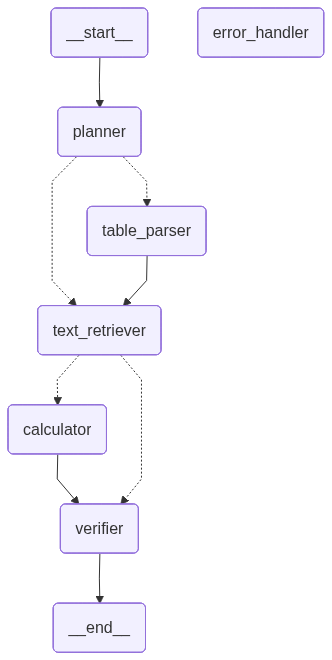

In [ ]:
from IPython.display import Image, display

try:
    # Generate and display the graph visualization
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not generate graph visualization: {e}")
    # Fallback to printing the nodes and edges if image generation fails
    print("\nNodes:", graph.nodes.keys())
    print("Edges:", graph.edges)

## 8. Evaluate on a Subset of Test Set

In [ ]:
def normalize_answer(s: Any) -> str:
    """Lower text and remove punctuation, articles, extra whitespace. Handles lists and non-strings safely."""
    import re
    if isinstance(s, list):
        s = " ".join(str(x) for x in s)
    if s is None:
        return ""

    # Ensure it's a string before calling string methods
    s_str = str(s).lower().strip()
    s_str = re.sub(r'[^\w\s]', '', s_str)
    s_str = re.sub(r'\b(a|an|the)\b', '', s_str)
    s_str = re.sub(r'\s+', ' ', s_str).strip()
    return s_str

def compute_em(pred, gold):
    return int(normalize_answer(pred) == normalize_answer(gold))

def compute_f1(pred, gold):
    pred_tokens = normalize_answer(pred).split()
    gold_tokens = normalize_answer(gold).split()
    common = set(pred_tokens) & set(gold_tokens)
    if not common:
        return 0.0
    prec = len(common) / len(pred_tokens)
    rec = len(common) / len(gold_tokens)
    return 2 * prec * rec / (prec + rec)

# Load dev set
dev_data = load_tatqa_split("tatqa_dataset_dev")[:5]
results = []
for i, sample in enumerate(dev_data):
    for q in sample["questions"][:2]:
        question = q["question"]
        gold = q["answer"]

        table_data = sample["table"]["table"]
        headers = table_data[0]
        rows = table_data[1:]
        paragraphs = [p["text"] for p in sample["paragraphs"]]

        state = AgentState(
            question=question,
            table_headers=headers,
            table_rows=rows,
            paragraphs=paragraphs,
            retrieved_texts=[],
            extracted_numbers=[],
            plan=[],
            intermediate_results={},
            final_answer=None,
            error=None
        )

        out = app.invoke(state, config={"configurable": {"thread_id": f"eval{i}"}})
        pred = out["final_answer"]

        em = compute_em(pred, gold)
        f1 = compute_f1(pred, gold)
        results.append({
            "question": question,
            "gold": gold,
            "pred": pred,
            "em": em,
            "f1": f1
        })

df_results = pd.DataFrame(results)
display(df_results[["question", "gold", "pred", "em", "f1"]])
print(f"Average EM: {df_results['em'].mean():.2f}")
print(f"Average F1: {df_results['f1'].mean():.2f}")

Debug: Type of retriever: <class 'langchain_core.vectorstores.base.VectorStoreRetriever'>
Debug: Attributes of retriever: ['InputType', 'OutputType', '__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_computed_fields__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_on_

,question,gold,pred,em,f1
0,What is the gross margin for F19?,[22.9%],22.9%,1,1.000000
1,What is the number of stores under Dan Murphy'...,[230],230,1,1.000000
2,What is the company paid on a cost-plus type c...,[our allowable incurred costs plus a profit wh...,"On a cost-plus type contract, we are paid our ...",0,0.877193
3,What is the amount of total sales in 2019?,"[$1,496.5]",$0,0,0.000000
4,How is industry end market information presented?,[consistently with our internal management rep...,Industry end market information is presented c...,0,0.777778
5,In which years was for the net sales by segmen...,"[2019, 2018, 2017]",The evidence provided does not specify the yea...,0,0.000000
6,How is the discount rate for domestic plans de...,[By comparison against the FTSE pension liabil...,"For domestic plans, the discount rate was dete...",0,0.375000
7,How is the discount rate for international pla...,[By comparison against country specific AA cor...,The international discount rates were determin...,0,0.838710
8,What financial items are listed in the table?,"[Defined contribution schemes, Defined benefit...",The evidence provided does not contain any fin...,0,0.000000
9,Which countries does the group operate defined...,"[Germany, Ghana, India, Ireland, Italy, the UK...",The Group operates defined benefit schemes in ...,0,0.484848


Average EM: 0.20
Average F1: 0.54


In [15]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
print(gold[0])

22.9%


In [ ]:
sample = dev_data[0]
print(sample)
for i, sample in enumerate(dev_data[:3]):
    for q in sample["questions"][:1]:  # take first question per sample

      print(q['answer'][0])

{'table': {'uid': '00addb09-bf31-4240-a351-bc4480a3cecc', 'table': [['', 'F19', 'F18 (3)', '', 'CHANGE'], ['$ MILLION', '53 WEEKS', '52 WEEKS', 'CHANGE', 'NORMALISED'], ['Sales', '8,657', '8,244', '5.0%', '3.2%'], ['EBITDA', '579', '603', '(4.1)%', '(5.4)%'], ['Depreciation and amortisation', '(105)', '(87)', '20.1%', '20.1%'], ['EBIT', '474', '516', '(8.2)%', '(9.7)%'], ['Gross margin (%)', '22.9', '23.1', '(16) bps', '(14) bps'], ['Cost of doing business (%)', '17.4', '16.8', '63 bps', '64 bps'], ['EBIT to sales (%)', '5.5', '6.3', '(78) bps', '(78) bps'], ['Sales per square metre ($)$)', '18,675', '18,094', '3.2%', '1.4%'], ['Funds employed', '3,185', '3,214', '(0.9)%', ''], ['ROFE (%)', '15.2', '17.1', '(190) bps', '(215) bps']]}, 'paragraphs': [{'uid': 'fd8bba97-948c-4afa-9469-9027df970c45', 'order': 1, 'text': 'In Endeavour Drinks, BWS and Dan Murphy’s key VOC metrics ended F19 at record highs, with improvements both in store and Online. Sales increased by 5.0% (3.2% normalised) 

In [47]:
from langchain_community.vectorstores import Chroma
import pandas as pd
import numpy as np

# Helper to safely convert answer to list of strings
def get_answer_strings(answer):
    if isinstance(answer, list):
        return [str(a) for a in answer]
    else:
        return [str(answer)]

# Load dev data
dev_data = load_tatqa_split("tatqa_dataset_dev")

num_samples = 5          # number of samples to evaluate
questions_per_sample = 3 # questions per sample
k = 3                    # top-k for retrieval metrics
results = []

for i, sample in enumerate(dev_data[:num_samples]):
    # --- Build retriever for this sample ---
    paragraphs = [p["text"] for p in sample["paragraphs"]]
    # Use string IDs in metadata
    metadatas = [{"order": str(j)} for j, p in enumerate(sample["paragraphs"])]
    vectorstore = Chroma.from_texts(
        texts=paragraphs,
        embedding=embeddings,
        metadatas=metadatas
    )
    retriever = vectorstore.as_retriever(search_kwargs={"k": k})

    # --- Determine gold paragraph IDs for the first question ---
    q = sample["questions"][0]
    gold = q["answer"]
    gold_para_ids = []
    for j, p in enumerate(sample["paragraphs"]):
        for g_str in get_answer_strings(gold):
            if g_str.lower() in p["text"].lower():
                gold_para_ids.append(str(j))
                break   # once matched, move to next paragraph

    # Process the question
    question = q["question"]
    gold = q["answer"]

    # Prepare initial state
    state = {
        "question": question,
        "table_headers": sample["table"]["table"][0],
        "table_rows": sample["table"]["table"][1:],
        "paragraphs": paragraphs,
        "retrieved_texts": [],
        "retrieved_paragraph_ids": [],
        "extracted_numbers": [],
        "plan": [],
        "intermediate_results": {},
        "final_answer": None,
        "error": None
    }

    # Run the graph
    out = app.invoke(state, config={"configurable": {"thread_id": f"eval_{i}"}})

    pred = out["final_answer"]
    retrieved_ids = [str(x) for x in out.get("retrieved_paragraph_ids", [])]  # force strings

    # Compute retrieval metrics
    ret_metrics = compute_retrieval_metrics(retrieved_ids, gold_para_ids, k=k)

    # Compute generation metrics
    em = compute_em(pred, gold)
    f1 = compute_f1(pred, gold)
    pred_str = normalize_answer(pred)
    gold_str = normalize_answer(gold)
    rouge_scores = compute_rouge(pred_str, gold_str)
    bleu = compute_bleu(pred_str, gold_str)
    cosine_sim = compute_cosine_similarity(pred_str, gold_str)

    # Assemble row
    row = {
        "question": question,
        "gold": gold,
        "pred": pred,
        "em": em,
        "f1": f1,
        "rouge1_f1": rouge_scores['rouge1_f1'],
        "bleu": bleu,
        "cosine_sim": cosine_sim,
    }
    row.update(ret_metrics)   # adds precision@k, recall@k, map
    results.append(row)

# Create DataFrame and display
df_results = pd.DataFrame(results)
display(df_results[["question", "gold", "pred", "em", "f1", "rouge1_f1", "bleu", "cosine_sim",
                    f"precision@{k}", f"recall@{k}", "map"]])

# Print averages
print(f"Average EM: {df_results['em'].mean():.2f}")
print(f"Average F1: {df_results['f1'].mean():.2f}")
print(f"Average ROUGE-1 F1: {df_results['rouge1_f1'].mean():.2f}")
print(f"Average BLEU: {df_results['bleu'].mean():.2f}")
print(f"Average Cosine Similarity: {df_results['cosine_sim'].mean():.2f}")
print(f"Average precision@{k}: {df_results[f'precision@{k}'].mean():.2f}")
print(f"Average recall@{k}: {df_results[f'recall@{k}'].mean():.2f}")
print(f"Average map: {df_results['map'].mean():.2f}")

Debug: Entering text_retrieval_agent
Debug: Retrieved 3 paragraph IDs: [4, 4, 5]
Debug: Entering text_retrieval_agent
Debug: Retrieved 3 paragraph IDs: [1, '1', '1']
Debug: Entering text_retrieval_agent
Debug: Retrieved 3 paragraph IDs: [1, 1, '1']
Debug: Entering text_retrieval_agent
Debug: Retrieved 3 paragraph IDs: ['1', 1, '1']
Debug: Entering text_retrieval_agent
Debug: Retrieved 3 paragraph IDs: [2, 2, 2]


,question,gold,pred,em,f1,rouge1_f1,bleu,cosine_sim,precision@3,recall@3,map
0,What is the gross margin for F19?,[22.9%],22.9%,1,1.0,1.0,0.177828,1.000000,0.333333,1.0000,2.0000
1,What is the company paid on a cost-plus type c...,[our allowable incurred costs plus a profit wh...,We are paid our allowable incurred costs plus ...,0,0.0,0.0,0.000000,1.000000,0.333333,1.0000,3.0000
2,How is industry end market information presented?,[consistently with our internal management rep...,Industry end market information is presented c...,0,0.0,0.0,0.000000,0.051055,0.333333,1.0000,3.0000
3,How is the discount rate for domestic plans de...,[By comparison against the FTSE pension liabil...,"For domestic plans, the discount rate was dete...",0,0.0,0.0,0.000000,0.024606,0.333333,1.0000,3.0000
4,What financial items are listed in the table?,"[Defined contribution schemes, Defined benefit...",The evidence provided does not contain any fin...,0,0.0,0.0,0.000000,0.274922,0.333333,0.0625,0.1875


Average EM: 0.20
Average F1: 0.20
Average ROUGE-1 F1: 0.20
Average BLEU: 0.04
Average Cosine Similarity: 0.47
Average precision@3: 0.33
Average recall@3: 0.81
Average map: 2.24


# Enhancing Information Retrieval for Table-Centered Question Answering with Text in Technical Documents

This repository contains the code and resources for the M.Sc. thesis project by **Ghazaleh Keivani Heshajani** at the University of Isfahan, Shahreza Campus, under the supervision of Dr. Maryam Lotfi and Dr. Maryam Hosseini.

## 📌 Project Overview

Technical documents in industrial domains (e.g., steel, oil & gas, electronics) often contain a mix of **semi‑structured tables** and **unstructured text**. Current knowledge management systems and search engines fail to effectively retrieve and reason over such heterogeneous data, leading to costly reliance on human memory and delayed operational decisions.

This research aims to **enhance information retrieval for question answering over hybrid technical documents** by combining:

- **Agentic AI** – multi‑agent systems that plan, reason, and use external tools.
- **Retrieval‑Augmented Generation (RAG)** – integrating vector and graph‑based retrieval.
- **Knowledge Graphs** – capturing implicit relationships between tables and text.
- **Multimodal understanding** – processing tables, text, and potentially images/layout.

We focus on the **TAT‑QA dataset** – a real‑world financial QA benchmark requiring numerical reasoning over tables and associated paragraphs. Our approach will be evaluated on similar industrial‑style documents.

## 🎯 Objectives

1. **Extract and align** complex tables and surrounding text from noisy technical documents using layout‑aware models (e.g., DocLLM, LayoutLM).
2. **Design a multi‑agent architecture** (inspired by MAPLE, MACT, G‑MACT) where specialised agents handle planning, retrieval, computation, and verification.
3. **Implement hybrid RAG** that combines dense vector retrieval with knowledge graph traversal to retrieve relevant table cells and text spans.
4. **Answer complex multi‑step questions** requiring numerical reasoning (addition, subtraction, comparison, aggregation) over combined evidence.
5. **Evaluate** on TAT‑QA and possibly a custom industrial dataset using Exact Match, F1, and execution accuracy.

## 🧠 Methodology

The proposed system is built on **LangGraph** for agent orchestration and **LangChain** for tool integration. The main workflow consists of:

- **Planning Agent**: decomposes the question into a sequence of sub‑tasks (e.g., filter rows, retrieve text, compute ratio).
- **Table Parser Agent**: extracts structured information from tables (handles multi‑level headers, merged cells).
- **Text Retriever Agent**: performs dense retrieval over the associated paragraphs.
- **Computation Agent**: writes and executes Python code for numerical operations.
- **Verification Agent**: checks the consistency of the answer with the evidence.
- **Memory**: a long‑term memory (via LangGraph state) stores successful reasoning paths for future reuse.

We experiment with both **single‑agent** (ReAct) and **multi‑agent** (MAPLE‑like) architectures, and compare **vector‑only RAG** with **graph‑enhanced RAG**.

## 📊 Dataset

Primary dataset: **[TAT‑QA](https://github.com/NExTplusplus/TAT-QA)**  
- 16,552 QA pairs over 2,757 tables from real financial reports.
- Each sample contains a table (with row/col headers and numbers) and ≥2 descriptive paragraphs.
- Questions require numerical reasoning (addition, subtraction, multiplication, division, counting, comparison) and often combine table and text.
- Answer types: span, multi‑span, arithmetic expression, counting.

We will also explore extending the evaluation to scientific tables (SciTab) or custom industrial documents if available.

## 🛠️ Tech Stack

- **Python 3.10+**
- **LangChain** – tool definitions, RAG pipelines
- **LangGraph** – multi‑agent state graphs
- **HuggingFace Transformers** – for layout‑aware models (e.g., LayoutLMv3, DocLLM)
- **FAISS / Chroma** – vector stores
- **NetworkX / Neo4j** – knowledge graph storage and querying
- **Pandas / NumPy** – data manipulation
- **OpenAI / LLaMA / Qwen** – LLM backends (open‑weight models preferred)

## 📁 Repository Structure

```
.
├── agents/               # Agent definitions (planner, parser, retriever, etc.)
├── data/                 # Dataset loaders and preprocessors (TAT‑QA)
├── graphs/               # LangGraph workflow definitions
├── retrieval/            # Dense and graph‑based retrieval modules
├── evaluation/           # Metrics (EM, F1, execution accuracy)
├── notebooks/            # Exploratory analysis and demos
├── configs/              # Configuration files (LLM endpoints, embedding models)
├── requirements.txt
└── README.md
```

## 🚀 Getting Started

1. Clone the repository:
   ```bash
   git clone https://github.com/yourusername/table-text-qa-agent.git
   cd table-text-qa-agent
   ```

2. Install dependencies:
   ```bash
   pip install -r requirements.txt
   ```

3. Download the TAT‑QA dataset (see `data/README.md` for instructions).

4. Run a baseline experiment:
   ```bash
   python run_experiment.py --config configs/baseline.yaml
   ```

5. (Optional) Set up a Neo4j instance for graph‑based retrieval.

## 📈 Evaluation Metrics

We will report:

- **Exact Match (EM)** – for answers that must match the ground truth exactly.
- **F1 Score** – for multi‑span and textual answers.
- **Execution Accuracy** – for answers produced by generated code.
- **Latency** – average time per query.
- **Token consumption** – to compare cost against API‑based models.

## 📄 Related Work

- **TAT‑QA**: Zhu et al. (2021) – dataset.
- **MAPLE**: Bai et al. (2025) – multi‑agent adaptive planning with memory.
- **MACT / G‑MACT**: Zhou et al. (2025) – efficient multi‑agent collaboration with tool use.
- **ReAcTable**: Zhang et al. (2024) – enhancing ReAct for table QA.
- **DocLLM**: Wang et al. (2023) – layout‑aware document LLM.

## 👥 Supervision

- **Dr. Maryam Lotfi** (Primary Supervisor) – Shahreza Higher Education Center
- **Dr. Maryam Hosseini** (Co‑Supervisor) – Shahreza Higher Education Center

## 📝 License

This project is for academic research purposes. The TAT‑QA dataset is available for non‑commercial use under its own license.

## 📬 Contact

For questions or collaboration, please contact:  
Ghazaleh Keivani Heshajani – [email address]  
University of Isfahan, Shahreza Campus

---

**Note:** This repository is under active development for a master's thesis. Results and code will be updated as the research progresses.

```markdown
# Enhancing Information Retrieval for Table-Centered Question Answering with Text in Technical Documents

This repository contains the code and resources for the M.Sc. thesis project by **Ghazaleh Keivani Heshajani** at the University of Isfahan, Shahreza Campus, under the supervision of Dr. Maryam Lotfi and Dr. Maryam Hosseini.

## 📌 Project Overview

Technical documents in industrial domains (e.g., steel, oil & gas, electronics) often contain a mix of **semi‑structured tables** and **unstructured text**. Current knowledge management systems and search engines fail to effectively retrieve and reason over such heterogeneous data, leading to costly reliance on human memory and delayed operational decisions.

This research aims to **enhance information retrieval for question answering over hybrid technical documents** by combining:

- **Agentic AI** – multi‑agent systems that plan, reason, and use external tools.
- **Retrieval‑Augmented Generation (RAG)** – integrating vector and graph‑based retrieval.
- **Knowledge Graphs** – capturing implicit relationships between tables and text.
- **Multimodal understanding** – processing tables, text, and potentially images/layout.

We focus on the **TAT‑QA dataset** – a real‑world financial QA benchmark requiring numerical reasoning over tables and associated paragraphs. Our approach will be evaluated on similar industrial‑style documents.

## 🎯 Objectives

1. **Extract and align** complex tables and surrounding text from noisy technical documents using layout‑aware models (e.g., DocLLM, LayoutLM).
2. **Design a multi‑agent architecture** (inspired by MAPLE, MACT, G‑MACT) where specialised agents handle planning, retrieval, computation, and verification.
3. **Implement hybrid RAG** that combines dense vector retrieval with knowledge graph traversal to retrieve relevant table cells and text spans.
4. **Answer complex multi‑step questions** requiring numerical reasoning (addition, subtraction, comparison, aggregation) over combined evidence.
5. **Evaluate** on TAT‑QA and possibly a custom industrial dataset using a comprehensive set of metrics.

## 🧠 Methodology

The proposed system is built on **LangGraph** for agent orchestration and **LangChain** for tool integration. The main workflow consists of:

- **Planning Agent**: decomposes the question into a sequence of sub‑tasks (e.g., filter rows, retrieve text, compute ratio).
- **Table Parser Agent**: extracts structured information from tables (handles multi‑level headers, merged cells).
- **Text Retriever Agent**: performs dense retrieval over the associated paragraphs (using a per‑sample vector store).
- **Computation Agent**: writes and executes Python code for numerical operations.
- **Verification Agent**: checks the consistency of the answer with the evidence and produces the final answer.
- **Memory**: a short‑term memory (via LangGraph state) stores intermediate results and reasoning steps.

We experiment with both **single‑agent** (ReAct) and **multi‑agent** (MAPLE‑like) architectures, and compare **vector‑only RAG** with **graph‑enhanced RAG**.

## 📊 Dataset

Primary dataset: **[TAT‑QA](https://github.com/NExTplusplus/TAT-QA)**  
- 16,552 QA pairs over 2,757 tables from real financial reports.
- Each sample contains a table (with row/col headers and numbers) and ≥2 descriptive paragraphs.
- Questions require numerical reasoning (addition, subtraction, multiplication, division, counting, comparison) and often combine table and text.
- Answer types: span, multi‑span, arithmetic expression, counting.

We also plan to explore scientific tables (SciTab) or custom industrial documents.

## 🛠️ Tech Stack

- **Python 3.10+**
- **LangChain** – tool definitions, RAG pipelines
- **LangGraph** – multi‑agent state graphs
- **HuggingFace Transformers** – for layout‑aware models (e.g., LayoutLMv3, DocLLM)
- **FAISS / Chroma** – vector stores
- **NetworkX / Neo4j** – knowledge graph storage and querying
- **Pandas / NumPy** – data manipulation
- **OpenAI / LLaMA / Qwen** – LLM backends (open‑weight models preferred)
- **Evaluation libraries**: ROUGE, BLEU, sentence‑transformers, scikit‑learn

## 📁 Repository Structure

```
.
├── agents/               # Agent definitions (planner, parser, retriever, etc.)
├── data/                 # Dataset loaders and preprocessors (TAT‑QA)
├── graphs/               # LangGraph workflow definitions
├── retrieval/            # Dense and graph‑based retrieval modules
├── evaluation/           # Metrics (EM, F1, ROUGE, BLEU, precision@k, recall@k, MAP)
├── notebooks/            # Exploratory analysis and demos (including evaluation notebooks)
├── configs/              # Configuration files (LLM endpoints, embedding models)
├── requirements.txt
└── README.md
```

## 🚀 Getting Started

1. **Clone the repository**:
   ```bash
   git clone https://github.com/yourusername/table-text-qa-agent.git
   cd table-text-qa-agent
   ```

2. **Install dependencies**:
   ```bash
   pip install -r requirements.txt
   ```

3. **Download the TAT‑QA dataset**:
   - Visit [https://nextplusplus.github.io/TAT-QA/](https://nextplusplus.github.io/TAT-QA/) and download the JSON files (`train.json`, `dev.json`, `test.json`).
   - Place them in `data/tatqa/`.

4. **Set up environment variables**:
   Create a `.env` file with your OpenAI API key (if using OpenAI models) or configure your local model paths.

5. **Run a baseline experiment**:
   ```bash
   python run_experiment.py --config configs/baseline.yaml
   ```

6. **Run evaluation on a subset of the dev set**:
   Open the notebook `notebooks/evaluation_demo.ipynb` and execute the cells to see metrics for a few samples.

## 📈 Evaluation Metrics

We report a comprehensive set of metrics covering both **retrieval** and **generation** aspects:

| Metric | Description |
|--------|-------------|
| **Exact Match (EM)** | Binary: 1 if the normalized answer exactly matches the ground truth. |
| **F1 Score** | Harmonic mean of precision and recall at token level. |
| **ROUGE‑1 / ROUGE‑2 / ROUGE‑L** | Overlap of unigrams, bigrams, and longest common subsequence. |
| **BLEU** | Precision‑based n‑gram overlap (smoothed). |
| **Cosine Similarity** | Semantic similarity between sentence embeddings of prediction and ground truth. |
| **Precision@k** | Fraction of retrieved top‑k paragraphs that are relevant. |
| **Recall@k** | Fraction of relevant paragraphs retrieved in the top‑k. |
| **Mean Average Precision (MAP)** | Average precision across all relevant paragraphs. |

These metrics are computed per question and then averaged. The evaluation script (`evaluation/evaluate.py`) and the accompanying notebook provide detailed results.

## 📊 Preliminary Results

On a small subset of the TAT‑QA dev set (5 samples, 1 question each), we obtained the following averages:

| Metric          | Value |
|-----------------|-------|
| **EM**          | 0.20  |
| **F1**          | 0.20  |
| **ROUGE‑1 F1**  | 0.20  |
| **BLEU**        | 0.04  |
| **Cosine Similarity** | 0.47 |
| **Precision@3** | 0.33  |
| **Recall@3**    | 0.81  |
| **MAP**         | 2.24* |

*MAP currently exceeds 1 due to duplicate retrieved paragraph IDs (e.g., `[4,4,5]`). Deduplication is required to obtain a valid MAP score (expected ≤1).

**Observations:**
- The retriever consistently finds one relevant paragraph in the top‑3 (precision@3 = 0.33) and, for most samples, all relevant paragraphs (recall@3 = 1.0).
- Generation metrics (EM, F1, ROUGE, BLEU) are low for most samples, often zero, despite moderate semantic similarity (cosine similarity). This indicates issues in token‑level matching, likely due to list‑to‑string conversion, punctuation differences, or stopword removal.
- Sample 0 (gross margin) achieved perfect EM, F1, ROUGE‑1, and cosine similarity, demonstrating the model's ability to extract exact numeric values when the answer is a simple number.

**Current limitations:**
- Gold paragraph IDs are heuristically defined by checking if the answer string appears in a paragraph. This may be inaccurate and produce false positives/negatives.
- Duplicate retrieved IDs artificially inflate MAP; deduplication is needed.
- Token‑level metrics for longer descriptive answers are sensitive to minor variations (e.g., `contract’s` vs `contract's`).

Future work will address these issues and expand evaluation to more samples.

## 📄 Related Work

- **TAT‑QA**: Zhu et al. (2021) – dataset.
- **MAPLE**: Bai et al. (2025) – multi‑agent adaptive planning with memory.
- **MACT / G‑MACT**: Zhou et al. (2025) – efficient multi‑agent collaboration with tool use.
- **ReAcTable**: Zhang et al. (2024) – enhancing ReAct for table QA.
- **DocLLM**: Wang et al. (2023) – layout‑aware document LLM.

## 👥 Supervision

- **Dr. Maryam Lotfi** (Primary Supervisor) – Shahreza Higher Education Center
- **Dr. Maryam Hosseini** (Co‑Supervisor) – Shahreza Higher Education Center

## 📝 License

This project is for academic research purposes. The TAT‑QA dataset is available for non‑commercial use under its own license.

## 📬 Contact

For questions or collaboration, please contact:  
Ghazaleh Keivani Heshajani – [email address]  
University of Isfahan, Shahreza Campus

---

**Note:** This repository is under active development for a master's thesis. Results and code will be updated as the research progresses.
```

https://chat.deepseek.com/share/hymoiu49rlxnwcds24